# PINN

Epoch [1000/25000], Loss: 1.411992
Epoch [2000/25000], Loss: 0.974919
Epoch [3000/25000], Loss: 0.686460
Epoch [4000/25000], Loss: 0.556441
Epoch [5000/25000], Loss: 0.407367
Epoch [6000/25000], Loss: 0.325125
Epoch [7000/25000], Loss: 0.259115
Epoch [8000/25000], Loss: 0.205524
Epoch [9000/25000], Loss: 0.115083
Epoch [10000/25000], Loss: 0.037973
Epoch [11000/25000], Loss: 0.016151
Epoch [12000/25000], Loss: 0.007702
Epoch [13000/25000], Loss: 0.004216
Epoch [14000/25000], Loss: 0.014517
Epoch [15000/25000], Loss: 0.002353
Epoch [16000/25000], Loss: 0.001982
Epoch [17000/25000], Loss: 0.005461
Epoch [18000/25000], Loss: 0.002169
Epoch [19000/25000], Loss: 0.011969
Epoch [20000/25000], Loss: 0.004255
Epoch [21000/25000], Loss: 0.001196
Epoch [22000/25000], Loss: 0.001089
Epoch [23000/25000], Loss: 0.001479
Epoch [24000/25000], Loss: 0.000946
Epoch [25000/25000], Loss: 0.001760
Relative L2 Error: 1.4849921800484573


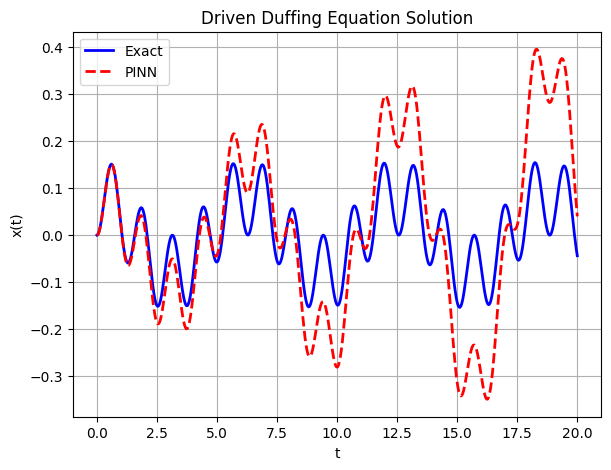

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.animation import FuncAnimation, PillowWriter
import os
np.random.seed(34)
torch.manual_seed(34)
class DrivenDuffingPINN(nn.Module):
    def __init__(self, layers):
        super(DrivenDuffingPINN, self).__init__()
        
        # Duffing方程参数
        self.alpha = 1.0    # 线性项系数
        self.beta = 0.5     # 非线性项系数
        self.gamma = 2.0    # 驱动力幅度
        self.omega = 5.0    # 驱动频率（高频）
        
        # 构建神经网络
        self.layers = layers
        self.activation = nn.Tanh()
        self.linear_layers = nn.ModuleList()
        
        for i in range(len(layers)-1):
            self.linear_layers.append(nn.Linear(layers[i], layers[i+1]))
            
        # 初始化权重
        for layer in self.linear_layers:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)
            
    def forward(self, t):
        x = t
        for i in range(len(self.layers)-2):
            x = self.linear_layers[i](x)
            x = self.activation(x)
        x = self.linear_layers[-1](x)
        return x
    
    def loss_fn(self, t):
        t.requires_grad_(True)
        x = self.forward(t)
        
        dx_dt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x),
                                  create_graph=True)[0]
        
        d2x_dt2 = torch.autograd.grad(dx_dt, t, grad_outputs=torch.ones_like(dx_dt),
                                    create_graph=True)[0]
        
        # d²x/dt² + αx + βx³ = γcos(ωt)
        residual = (d2x_dt2 + 
                   self.alpha * x + 
                   self.beta * x**3 - 
                   self.gamma * torch.cos(self.omega * t))
        
        loss_pde = torch.mean(residual**2)
        
        # 初始条件: x(0)=0, dx/dt(0)=0
        loss_ic = torch.mean((x[0] - 0.0)**2 + (dx_dt[0] - 0.0)**2)
        
        #return loss_pde + 100*loss_ic
        return loss_pde + loss_ic

t = np.linspace(0, 20, 500)  # 增加采样点数
t_torch = torch.tensor(t.reshape(-1, 1), dtype=torch.float32)

# 创建更大的网络以学习复杂特征
layers = [1, 50, 50, 50, 1]  
model = DrivenDuffingPINN(layers)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
predictions_history = []
# 训练循环
weight_history = {name: [] for name, _ in model.named_parameters()}
epochs = 25000
predictions_history=[]

# 训练循环
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = model.loss_fn(t_torch)
    loss.backward()
    optimizer.step()

    # 打印损失信息
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}")
    if epoch % 100 == 0:
        with torch.no_grad():
            predictions_history.append(model(t_torch).detach().numpy())
# 生成预测结果
model.eval()
with torch.no_grad():
    x_pred = model(t_torch).numpy()

# 用odeint求解精确解
def driven_duffing(state, t, alpha, beta, gamma, omega):
    x, dx_dt = state
    d2x_dt2 = gamma * np.cos(omega * t) - alpha * x - beta * x**3
    return [dx_dt, d2x_dt2]

initial_state = [0.0, 0.0]
params = (1.0, 0.5, 2.0, 5.0)  # alpha, beta, gamma, omega

solution = odeint(driven_duffing, initial_state, t, args=params)
x_exact = solution[:, 0]


# 绘制结果
plt.figure(figsize=(15, 5))

# 完整解
plt.subplot(121)
plt.plot(t, x_exact, 'b-', label='Exact', linewidth=2)
plt.plot(t, x_pred, 'r--', label='PINN', linewidth=2)
plt.xlabel('t')
plt.ylabel('x(t)')
plt.title('Driven Duffing Equation Solution')
plt.legend()
plt.grid(True)

from scipy.interpolate import interp1d
t= np.linspace(0, 20, 500)  #
t_torch=torch.tensor(t.reshape(-1, 1), dtype=torch.float32)
# 生成预测结果
model.eval()
with torch.no_grad():
    x_pred = model(t_torch).numpy()
initial_state = [0.0, 0.0]

params = (1.0, 0.5, 2.0, 5.0)  # alpha, beta, gamma, omega

solution = odeint(driven_duffing, initial_state, t, args=params,atol=1e-8, rtol=1e-8)
x_exact = solution[:, 0]
interp_exact = interp1d(t, x_exact, kind='cubic')

x_exact_interp = interp_exact(t_torch.detach().numpy().flatten())

# 计算相对误差
error = np.linalg.norm((x_pred.flatten() - x_exact_interp),2) / np.linalg.norm(x_exact_interp,2)
print(f'Relative L2 Error: {error}')

# SPF-PINN-2

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random 
np.random.seed(34)
torch.manual_seed(34)

# Duffing方程神经网络
class DrivenDuffingPINN(nn.Module):
    def __init__(self, layers):
        super(DrivenDuffingPINN, self).__init__()
        self.alpha = 1.0
        self.beta = 0.5
        self.gamma = 2.0
        self.omega = 5.0
        
        self.layers = layers
        self.activation = nn.Tanh()
        self.linear_layers = nn.ModuleList()
        
        for i in range(len(layers) - 1):
            self.linear_layers.append(nn.Linear(layers[i], layers[i + 1]))
        
        for layer in self.linear_layers:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)
            
    def forward(self, t):
        x = t
        for i in range(len(self.layers) - 2):
            x = self.linear_layers[i](x)
            x = self.activation(x)
        x = self.linear_layers[-1](x)
        return x
    
    def loss_fn(self, t):
        t.requires_grad_(True)
        x = self.forward(t)
        dx_dt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
        d2x_dt2 = torch.autograd.grad(dx_dt, t, grad_outputs=torch.ones_like(dx_dt), create_graph=True)[0]
        
        residual = (d2x_dt2 + self.alpha * x + self.beta * x**3 - self.gamma * torch.cos(self.omega * t))
        loss_pde = torch.mean(residual**2)
        loss_ic = torch.mean((x[0] - 0.0) ** 2 + (dx_dt[0] - 0.0) ** 2)
        return loss_pde + loss_ic

# 生成掩码
def generate_mask(weight_history, n, m, threshold):
    weight_diffs = {}
    for name, weights in weight_history.items():
        if len(weights) >= n + m - 1:
            weight_n = np.array(weights[n - 1])
            weight_n_m = np.array(weights[n + m - 1])
            weight_diffs[name] = np.abs(weight_n - weight_n_m)
    
    masks = {}
    for name, param in model.named_parameters():
        weight_diff = weight_diffs.get(name, None)
        if weight_diff is not None:
            mask = torch.ones_like(param.data)
            mask.view(-1)[weight_diff.flatten() < threshold] = 0
            masks[name] = mask
        else:
            masks[name] = torch.ones_like(param.data)
    return masks

# 训练
def train_with_mask(masks, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        loss = model.loss_fn(t_torch)
        loss.backward()
        for name, param in model.named_parameters():
            if param.requires_grad and masks[name] is not None:
                if param.grad is not None:
                    param.grad *= masks[name].detach()
        # 继续记录权重变化
        for name, param in model.named_parameters():
            weight_history[name].append(param.clone().detach().numpy().flatten())
        optimizer.step()
        if (epoch+1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')
        if epoch % 100 == 0:
                with torch.no_grad():
                    predictions_history_freezing_2.append(model(t_torch).detach().numpy())

# 生成训练数据
t = np.linspace(0, 20, 500)
t_torch = torch.tensor(t.reshape(-1, 1), dtype=torch.float32)

# 创建神经网络
layers = [1, 50, 50, 50, 1]
# 训练步骤
total_steps = 25000

num_1=[5000]
num_2=[15000]
predictions_history_freezing_2 = []
thresholds = [1e-3, 1e-3]
L2_errors = []

for i in range(len(num_1)):   
    model = DrivenDuffingPINN(layers)
    weight_history = {name: [] for name, _ in model.named_parameters()}
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_1[i]):
        optimizer.zero_grad()
        loss = model.loss_fn(t_torch)
        loss.backward()
        optimizer.step()
        for name, param in model.named_parameters():
            weight_history[name].append(param.clone().detach().numpy().flatten())
        if (epoch+1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{num_1[i]}], Loss: {loss.item():.6f}')
        if epoch % 100 == 0:
                with torch.no_grad():
                    predictions_history_freezing_2.append(model(t_torch).detach().numpy())
    
    
    n, m = num_1[i]-1000, 1000
    masks = generate_mask(weight_history, n, m, thresholds[i])
    epochs =num_2[i]- num_1[i]
    train_with_mask(masks, optimizer, epochs)
    
    n, m = num_2[i]-1000, 1000
    masks = generate_mask(weight_history, n, m, thresholds[i])
    epochs =total_steps- num_2[i]
    train_with_mask(masks, optimizer,epochs)
    

    model.eval()
    with torch.no_grad():
        x_pred = model(t_torch).numpy()
    
    def driven_duffing(state, t, alpha, beta, gamma, omega):
        x, dx_dt = state
        d2x_dt2 = gamma * np.cos(omega * t) - alpha * x - beta * x**3
        return [dx_dt, d2x_dt2]
    
    initial_state = [0.0, 0.0]
    params = (1.0, 0.5, 2.0, 5.0)
    solution = odeint(driven_duffing, initial_state, t, args=params)
    x_exact = solution[:, 0]
    error = np.linalg.norm((x_pred.flatten() - x_exact), 2) / np.linalg.norm(x_exact, 2)
    L2_errors.append(error)
    print(f'Iteration {i + 1}, L2 Error: {error}')

print("Final L2 Errors:", L2_errors)

Epoch [1000/5000], Loss: 1.411992
Epoch [2000/5000], Loss: 0.974919
Epoch [3000/5000], Loss: 0.686460
Epoch [4000/5000], Loss: 0.556441
Epoch [5000/5000], Loss: 0.407367
Epoch [1000/10000], Loss: 0.325512
Epoch [2000/10000], Loss: 0.254605
Epoch [3000/10000], Loss: 0.202909
Epoch [4000/10000], Loss: 0.119180
Epoch [5000/10000], Loss: 0.044668
Epoch [6000/10000], Loss: 0.017651
Epoch [7000/10000], Loss: 0.013873
Epoch [8000/10000], Loss: 0.005054
Epoch [9000/10000], Loss: 0.002985
Epoch [10000/10000], Loss: 0.002400
Epoch [1000/10000], Loss: 0.002006
Epoch [2000/10000], Loss: 0.000977
Epoch [3000/10000], Loss: 0.000112
Epoch [4000/10000], Loss: 0.000029
Epoch [5000/10000], Loss: 0.000031
Epoch [6000/10000], Loss: 0.000179
Epoch [7000/10000], Loss: 0.000008
Epoch [8000/10000], Loss: 0.000006
Epoch [9000/10000], Loss: 0.000005
Epoch [10000/10000], Loss: 0.000007
Iteration 1, L2 Error: 0.011151236927937135
Final L2 Errors: [0.011151236927937135]


# SPF-PINN-4

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random 
np.random.seed(34)
torch.manual_seed(34)

# Duffing方程神经网络
class DrivenDuffingPINN(nn.Module):
    def __init__(self, layers):
        super(DrivenDuffingPINN, self).__init__()
        self.alpha = 1.0
        self.beta = 0.5
        self.gamma = 2.0
        self.omega = 5.0
        
        self.layers = layers
        self.activation = nn.Tanh()
        self.linear_layers = nn.ModuleList()
        
        for i in range(len(layers) - 1):
            self.linear_layers.append(nn.Linear(layers[i], layers[i + 1]))
        
        for layer in self.linear_layers:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)
            
    def forward(self, t):
        x = t
        for i in range(len(self.layers) - 2):
            x = self.linear_layers[i](x)
            x = self.activation(x)
        x = self.linear_layers[-1](x)
        return x
    
    def loss_fn(self, t):
        t.requires_grad_(True)
        x = self.forward(t)
        dx_dt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
        d2x_dt2 = torch.autograd.grad(dx_dt, t, grad_outputs=torch.ones_like(dx_dt), create_graph=True)[0]
        
        residual = (d2x_dt2 + self.alpha * x + self.beta * x**3 - self.gamma * torch.cos(self.omega * t))
        loss_pde = torch.mean(residual**2)
        loss_ic = torch.mean((x[0] - 0.0) ** 2 + (dx_dt[0] - 0.0) ** 2)
        return loss_pde + loss_ic

# 生成掩码
def generate_mask(weight_history, n, m, threshold):
    weight_diffs = {}
    for name, weights in weight_history.items():
        if len(weights) >= n + m - 1:
            weight_n = np.array(weights[n - 1])
            weight_n_m = np.array(weights[n + m - 1])
            weight_diffs[name] = np.abs(weight_n - weight_n_m)
    
    masks = {}
    for name, param in model.named_parameters():
        weight_diff = weight_diffs.get(name, None)
        if weight_diff is not None:
            mask = torch.ones_like(param.data)
            mask.view(-1)[weight_diff.flatten() < threshold] = 0
            masks[name] = mask
        else:
            masks[name] = torch.ones_like(param.data)
    return masks

# 训练
def train_with_mask(masks, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        loss = model.loss_fn(t_torch)
        loss.backward()
        for name, param in model.named_parameters():
            if param.requires_grad and masks[name] is not None:
                if param.grad is not None:
                    param.grad *= masks[name].detach()
        # 继续记录权重变化
        for name, param in model.named_parameters():
            weight_history[name].append(param.clone().detach().numpy().flatten())
        optimizer.step()
        if (epoch+1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')
        if epoch % 100 == 0:
            with torch.no_grad():
                predictions_history_freezing.append(model(t_torch).detach().numpy())
# 生成训练数据
t = np.linspace(0, 20, 500)
t_torch = torch.tensor(t.reshape(-1, 1), dtype=torch.float32)

# 创建神经网络
layers = [1, 50, 50, 50, 1]
# 训练步骤
total_steps = 25000
predictions_history_freezing=[]
num_1=[5000]
num_2=[10000]
num_3=[15000]
num_4=[20000]
thresholds = [1e-3, 1e-3, 1e-3, 1e-3]
L2_errors = []

for i in range(len(num_1)):   
    model = DrivenDuffingPINN(layers)
    weight_history = {name: [] for name, _ in model.named_parameters()}
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    weight_history = {name: [] for name, _ in model.named_parameters()}
    for epoch in range(num_1[i]):
        optimizer.zero_grad()
        loss = model.loss_fn(t_torch)
        loss.backward()
        optimizer.step()
        for name, param in model.named_parameters():
            weight_history[name].append(param.clone().detach().numpy().flatten())
        if (epoch+1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{num_1[i]}], Loss: {loss.item():.6f}')
        if epoch % 100 == 0:
            with torch.no_grad():
                predictions_history_freezing.append(model(t_torch).detach().numpy())
    
    
    n, m = num_1[i]-1000, 1000
    masks = generate_mask(weight_history, n, m, thresholds[i])
    epochs =num_2[i]- num_1[i]
    train_with_mask(masks, optimizer, epochs)
    
    n, m = num_2[i]-1000, 1000
    masks = generate_mask(weight_history, n, m, thresholds[i])
    epochs =num_3[i]- num_2[i]
    train_with_mask(masks, optimizer,epochs)
    
    n, m = num_3[i]-1000, 1000
    masks = generate_mask(weight_history, n, m, thresholds[i])
    epochs =num_4[i]- num_3[i]
    train_with_mask(masks, optimizer, epochs)
    
    n, m = num_4[i]-1000 ,1000
    masks = generate_mask(weight_history, n, m, thresholds[i])
    epochs = total_steps - num_4[i]
    train_with_mask(masks, optimizer, epochs)
    

    model.eval()
    with torch.no_grad():
        x_pred = model(t_torch).numpy()
    
    def driven_duffing(state, t, alpha, beta, gamma, omega):
        x, dx_dt = state
        d2x_dt2 = gamma * np.cos(omega * t) - alpha * x - beta * x**3
        return [dx_dt, d2x_dt2]
    
    initial_state = [0.0, 0.0]
    params = (1.0, 0.5, 2.0, 5.0)
    solution = odeint(driven_duffing, initial_state, t, args=params)
    x_exact = solution[:, 0]
    error = np.linalg.norm((x_pred.flatten() - x_exact), 2) / np.linalg.norm(x_exact, 2)
    L2_errors.append(error)
    print(f'Iteration {i + 1}, L2 Error: {error}')

print("Final L2 Errors:", L2_errors)

Epoch [1000/5000], Loss: 1.411992
Epoch [2000/5000], Loss: 0.974919
Epoch [3000/5000], Loss: 0.686460
Epoch [4000/5000], Loss: 0.556441
Epoch [5000/5000], Loss: 0.407367
Epoch [1000/5000], Loss: 0.325512
Epoch [2000/5000], Loss: 0.254605
Epoch [3000/5000], Loss: 0.202909
Epoch [4000/5000], Loss: 0.119180
Epoch [5000/5000], Loss: 0.044668
Epoch [1000/5000], Loss: 0.017334
Epoch [2000/5000], Loss: 0.009068
Epoch [3000/5000], Loss: 0.004103
Epoch [4000/5000], Loss: 0.002916
Epoch [5000/5000], Loss: 0.002298
Epoch [1000/5000], Loss: 0.001882
Epoch [2000/5000], Loss: 0.000616
Epoch [3000/5000], Loss: 0.000060
Epoch [4000/5000], Loss: 0.000070
Epoch [5000/5000], Loss: 0.000018
Epoch [1000/5000], Loss: 0.000011
Epoch [2000/5000], Loss: 0.000013
Epoch [3000/5000], Loss: 0.000006
Epoch [4000/5000], Loss: 0.000005
Epoch [5000/5000], Loss: 0.000004
Iteration 1, L2 Error: 0.005391886513594247
Final L2 Errors: [0.005391886513594247]


# Equation-Learning-Comparision

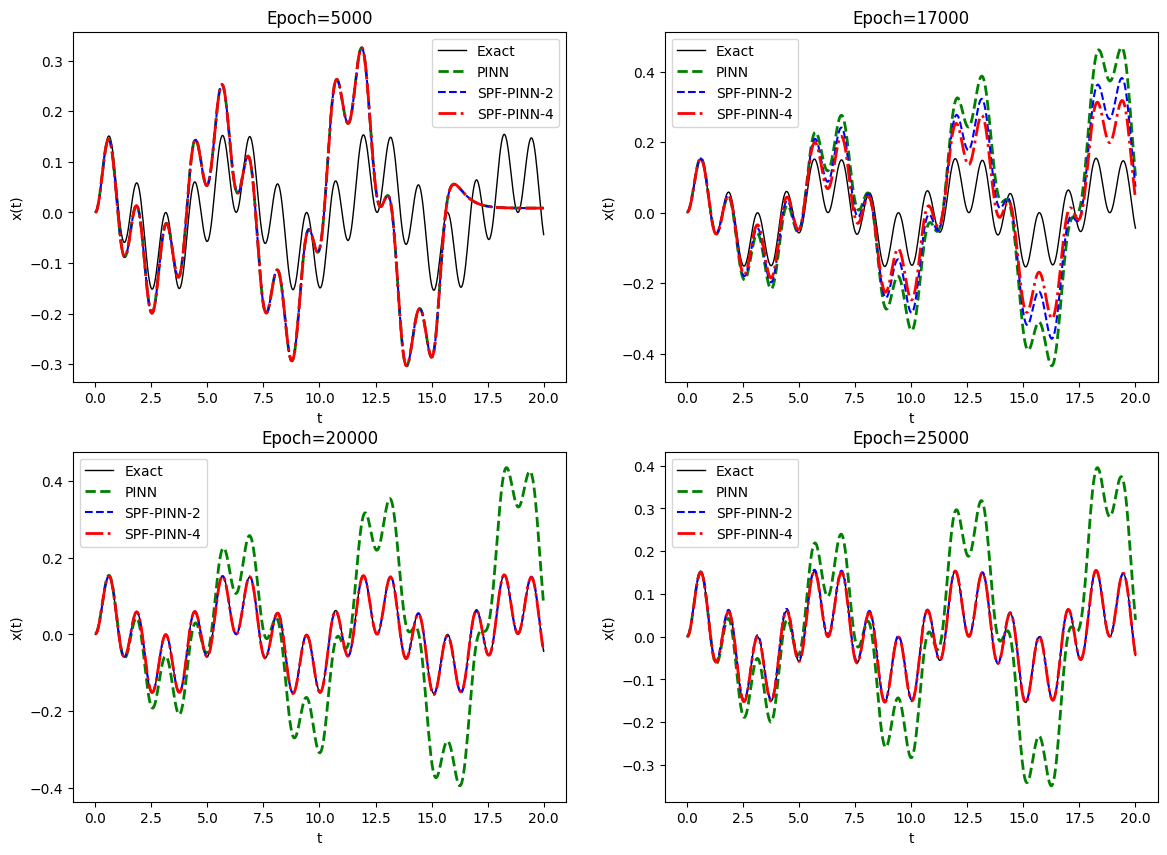

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# 指定展示步数
display_epochs = [5000, 17000, 20000, 24999]
display_epochs1 = [5000, 17000, 20000, 25000]
t = np.linspace(0, 20, 500)

# 确保步数范围正确
if max(display_epochs) > len(predictions_history) * 100:
    raise ValueError("The display_epochs exceed available prediction history.")

# 创建子图展示对比
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()


colors = ['black','g', 'r',  'b'] 
linestyles = ['-', '--', '-.', '--']  # 线型

for i, display_epoch in enumerate(display_epochs):
    index = display_epoch // 100  # 每100步存储一次预测结果
    axes[i].plot(t, x_exact, color=colors[0], linestyle=linestyles[0], label='Exact', linewidth=1)  # 蓝色
    axes[i].plot(
        t, predictions_history[index].flatten(),
        color=colors[1], linestyle=linestyles[1], label=f'PINN', linewidth=2  # 绿色
    )
    axes[i].plot(
        t,predictions_history_freezing_2[index].flatten(),
        color=colors[3], linestyle=linestyles[3], label=f'SPF-PINN-2', linewidth=1.5  # 紫色
    )
    axes[i].plot(
        t, predictions_history_freezing[index].flatten(),
        color=colors[2], linestyle=linestyles[2], label=f'SPF-PINN-4', linewidth=2  # 橙色
    )
    axes[i].set_xlabel('t')
    axes[i].set_ylabel('x(t)')
    axes[i].set_title(f'Epoch={display_epochs1[i]}')
    axes[i].legend()

plt.show()


# PINN+NTK

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.animation import FuncAnimation, PillowWriter
import os
np.random.seed(34)
torch.manual_seed(34)
class DrivenDuffingPINN(nn.Module):
    def __init__(self, layers):
        super(DrivenDuffingPINN, self).__init__()
        
        # Duffing方程参数
        self.alpha = 1.0    # 线性项系数
        self.beta = 0.5     # 非线性项系数
        self.gamma = 2.0    # 驱动力幅度
        self.omega = 5.0    # 驱动频率（高频）
        
        # 构建神经网络
        self.layers = layers
        self.activation = nn.Tanh()
        self.linear_layers = nn.ModuleList()
        
        for i in range(len(layers)-1):
            self.linear_layers.append(nn.Linear(layers[i], layers[i+1]))
            
        # 初始化权重
        for layer in self.linear_layers:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)
            
    def forward(self, t):
        x = t
        for i in range(len(self.layers)-2):
            x = self.linear_layers[i](x)
            x = self.activation(x)
        x = self.linear_layers[-1](x)
        return x
    
    def loss_fn(self, t):
        t.requires_grad_(True)
        x = self.forward(t)
        
        dx_dt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x),
                                  create_graph=True)[0]
        
        d2x_dt2 = torch.autograd.grad(dx_dt, t, grad_outputs=torch.ones_like(dx_dt),
                                    create_graph=True)[0]
        
        # d²x/dt² + αx + βx³ = γcos(ωt)
        residual = (d2x_dt2 + 
                   self.alpha * x + 
                   self.beta * x**3 - 
                   self.gamma * torch.cos(self.omega * t))
        
        loss_pde = torch.mean(residual**2)
        
        # 初始条件: x(0)=0, dx/dt(0)=0
        loss_ic = torch.mean((x[0] - 0.0)**2 + (dx_dt[0] - 0.0)**2)
        
        #return loss_pde + 100*loss_ic
        return loss_pde + loss_ic
# 生成更密的训练数据点以捕捉高频特征
t = np.linspace(0, 20, 1000)  # 增加采样点数
t_torch = torch.tensor(t.reshape(-1, 1), dtype=torch.float32)

# 创建更大的网络以学习复杂特征
layers = [1, 50, 50, 50, 1]  
model = DrivenDuffingPINN(layers)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
predictions_history_1 = []
# 训练循环
weight_history = {name: [] for name, _ in model.named_parameters()}
epochs = 25000
# 计算 PINN 的雅可比矩阵
def compute_jacobian_pinn(model, t, create_graph=True):
    u = model.forward(t)
    jacobian_list = []

    for i in range(u.shape[0]):
        grad_outputs = torch.zeros_like(u)
        grad_outputs[i] = 1.0
        grads = torch.autograd.grad(u, model.parameters(), grad_outputs=grad_outputs, 
                                   create_graph=create_graph, retain_graph=True)

        jacobian_list.append(torch.cat([g.view(-1) for g in grads]))
    
    return torch.stack(jacobian_list)

# 计算 Duffing 方程的雅可比矩阵
def compute_pde_jacobian(model, t, create_graph=True):
    t.requires_grad = True
    
    x = model.forward(t)
    dx_dt = torch.autograd.grad(x, t, torch.ones_like(x), create_graph=True, retain_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt, t, torch.ones_like(dx_dt), create_graph=True)[0]
    
    # Duffing 方程残差: d²x/dt² + αx + βx³ = γcos(ωt)
    residual = d2x_dt2 + model.alpha * x + model.beta * x**3 - model.gamma * torch.cos(model.omega * t)
    
    jacobian_list = []
    for i in range(residual.size(0)):
        grad_outputs = torch.ones_like(residual[i])
        grads = torch.autograd.grad(residual[i], model.parameters(), grad_outputs=grad_outputs,
                                    create_graph=create_graph, retain_graph=True)
        jacobian_list.append(torch.cat([g.view(-1) for g in grads]))
    
    return torch.stack(jacobian_list)
def compute_all_eigenvalues(K_uu, K_rr, K):

    # 计算Kuu的特征值
    eigenvalues_uu = np.sort(np.real(np.linalg.eigvals(K_uu.detach().numpy())))[::-1]
    
    # 计算Krr的特征值
    eigenvalues_rr = np.sort(np.real(np.linalg.eigvals(K_rr.detach().numpy())))[::-1]
    
    # 计算完整K矩阵的特征值
    eigenvalues_k = np.sort(np.real(np.linalg.eigvals(K.detach().numpy())))[::-1]
    
    return eigenvalues_uu, eigenvalues_rr, eigenvalues_k



# 计算 Duffing 方程的 NTK 和特征值
eigenvalues_uu_history1 = []
eigenvalues_rr_history1 = []
eigenvalues_k_history = []
interval = 500

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = model.loss_fn(t_torch)
    loss.backward()
    optimizer.step()
    for name, param in model.named_parameters():
        weight_history[name].append(param.clone().detach().numpy().flatten())
    if (epoch + 1) % interval == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}")
        
        # 计算 NTK 矩阵
        J_u = compute_jacobian_pinn(model, t_torch)
        J_r = compute_pde_jacobian(model, t_torch)
        
        K_uu = torch.mm(J_u, J_u.t()).detach()
        K_ur = torch.mm(J_u, J_r.t()).detach()
        K_ru = torch.mm(J_r, J_u.t()).detach()
        K_rr = torch.mm(J_r, J_r.t()).detach()
        K = torch.vstack([
            torch.hstack([K_uu, K_ur]),
            torch.hstack([K_ru, K_rr])
        ])
        
        print(f"K_uu shape: {K_uu.shape}")
        print(f"K_ur shape: {K_ur.shape}")
        print(f"K_ru shape: {K_ru.shape}")
        print(f"K_rr shape: {K_rr.shape}")
        print(f"K shape: {K.shape}")
        
        # 计算特征值
        eigenvalues_uu, eigenvalues_rr, eigenvalues_k = compute_all_eigenvalues(K_uu, K_rr, K)
        eigenvalues_uu_history1.append(eigenvalues_uu)
        eigenvalues_rr_history1.append(eigenvalues_rr)
        eigenvalues_k_history.append(eigenvalues_k)






# 生成预测结果
model.eval()
with torch.no_grad():
    x_pred = model(t_torch).numpy()

# 用odeint求解精确解
def driven_duffing(state, t, alpha, beta, gamma, omega):
    x, dx_dt = state
    d2x_dt2 = gamma * np.cos(omega * t) - alpha * x - beta * x**3
    return [dx_dt, d2x_dt2]

initial_state = [0.0, 0.0]
params = (1.0, 0.5, 2.0, 5.0)  # alpha, beta, gamma, omega

solution = odeint(driven_duffing, initial_state, t, args=params)
x_exact = solution[:, 0]


Epoch [500/25000], Loss: 1.652004
K_uu shape: torch.Size([1000, 1000])
K_ur shape: torch.Size([1000, 1000])
K_ru shape: torch.Size([1000, 1000])
K_rr shape: torch.Size([1000, 1000])
K shape: torch.Size([2000, 2000])
Epoch [1000/25000], Loss: 1.426150
K_uu shape: torch.Size([1000, 1000])
K_ur shape: torch.Size([1000, 1000])
K_ru shape: torch.Size([1000, 1000])
K_rr shape: torch.Size([1000, 1000])
K shape: torch.Size([2000, 2000])
Epoch [1500/25000], Loss: 1.199321
K_uu shape: torch.Size([1000, 1000])
K_ur shape: torch.Size([1000, 1000])
K_ru shape: torch.Size([1000, 1000])
K_rr shape: torch.Size([1000, 1000])
K shape: torch.Size([2000, 2000])
Epoch [2000/25000], Loss: 1.041594
K_uu shape: torch.Size([1000, 1000])
K_ur shape: torch.Size([1000, 1000])
K_ru shape: torch.Size([1000, 1000])
K_rr shape: torch.Size([1000, 1000])
K shape: torch.Size([2000, 2000])
Epoch [2500/25000], Loss: 0.959943
K_uu shape: torch.Size([1000, 1000])
K_ur shape: torch.Size([1000, 1000])
K_ru shape: torch.Size([

Epoch [19500/25000], Loss: 0.000318
K_uu shape: torch.Size([1000, 1000])
K_ur shape: torch.Size([1000, 1000])
K_ru shape: torch.Size([1000, 1000])
K_rr shape: torch.Size([1000, 1000])
K shape: torch.Size([2000, 2000])
Epoch [20000/25000], Loss: 0.008195
K_uu shape: torch.Size([1000, 1000])
K_ur shape: torch.Size([1000, 1000])
K_ru shape: torch.Size([1000, 1000])
K_rr shape: torch.Size([1000, 1000])
K shape: torch.Size([2000, 2000])
Epoch [20500/25000], Loss: 0.001465
K_uu shape: torch.Size([1000, 1000])
K_ur shape: torch.Size([1000, 1000])
K_ru shape: torch.Size([1000, 1000])
K_rr shape: torch.Size([1000, 1000])
K shape: torch.Size([2000, 2000])
Epoch [21000/25000], Loss: 0.010778
K_uu shape: torch.Size([1000, 1000])
K_ur shape: torch.Size([1000, 1000])
K_ru shape: torch.Size([1000, 1000])
K_rr shape: torch.Size([1000, 1000])
K shape: torch.Size([2000, 2000])
Epoch [21500/25000], Loss: 0.024100
K_uu shape: torch.Size([1000, 1000])
K_ur shape: torch.Size([1000, 1000])
K_ru shape: torch.

# SPF-PINN-4+NTK

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.animation import FuncAnimation, PillowWriter
import os
np.random.seed(34)
torch.manual_seed(34)
class DrivenDuffingPINN(nn.Module):
    def __init__(self, layers):
        super(DrivenDuffingPINN, self).__init__()
        
        # Duffing方程参数
        self.alpha = 1.0    # 线性项系数
        self.beta = 0.5     # 非线性项系数
        self.gamma = 2.0    # 驱动力幅度
        self.omega = 5.0    # 驱动频率（高频）
        
        # 构建神经网络
        self.layers = layers
        self.activation = nn.Tanh()
        self.linear_layers = nn.ModuleList()
        
        for i in range(len(layers)-1):
            self.linear_layers.append(nn.Linear(layers[i], layers[i+1]))
            
        # 初始化权重
        for layer in self.linear_layers:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)
            
    def forward(self, t):
        x = t
        for i in range(len(self.layers)-2):
            x = self.linear_layers[i](x)
            x = self.activation(x)
        x = self.linear_layers[-1](x)
        return x
    
    def loss_fn(self, t):
        t.requires_grad_(True)
        x = self.forward(t)
        
        dx_dt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x),
                                  create_graph=True)[0]
        
        d2x_dt2 = torch.autograd.grad(dx_dt, t, grad_outputs=torch.ones_like(dx_dt),
                                    create_graph=True)[0]
        
        # d²x/dt² + αx + βx³ = γcos(ωt)
        residual = (d2x_dt2 + 
                   self.alpha * x + 
                   self.beta * x**3 - 
                   self.gamma * torch.cos(self.omega * t))
        
        loss_pde = torch.mean(residual**2)
        
        # 初始条件: x(0)=0, dx/dt(0)=0
        loss_ic = torch.mean((x[0] - 0.0)**2 + (dx_dt[0] - 0.0)**2)
        
        #return loss_pde + 100*loss_ic
        return loss_pde + loss_ic
# 生成更密的训练数据点以捕捉高频特征
t = np.linspace(0, 20, 1000)  # 增加采样点数
t_torch = torch.tensor(t.reshape(-1, 1), dtype=torch.float32)

# 创建更大的网络以学习复杂特征
layers = [1, 50, 50, 50, 1]  
model = DrivenDuffingPINN(layers)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
predictions_history_1 = []
# 训练循环
weight_history = {name: [] for name, _ in model.named_parameters()}
epochs = 25000
# 计算 PINN 的雅可比矩阵
def compute_jacobian_pinn(model, t, create_graph=True):
    u = model.forward(t)
    jacobian_list = []

    for i in range(u.shape[0]):
        grad_outputs = torch.zeros_like(u)
        grad_outputs[i] = 1.0
        grads = torch.autograd.grad(u, model.parameters(), grad_outputs=grad_outputs, 
                                   create_graph=create_graph, retain_graph=True)

        jacobian_list.append(torch.cat([g.view(-1) for g in grads]))
    
    return torch.stack(jacobian_list)

# 计算 Duffing 方程的雅可比矩阵
def compute_pde_jacobian(model, t, create_graph=True):
    t.requires_grad = True
    
    x = model.forward(t)
    dx_dt = torch.autograd.grad(x, t, torch.ones_like(x), create_graph=True, retain_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt, t, torch.ones_like(dx_dt), create_graph=True)[0]
    
    # Duffing 方程残差: d²x/dt² + αx + βx³ = γcos(ωt)
    residual = d2x_dt2 + model.alpha * x + model.beta * x**3 - model.gamma * torch.cos(model.omega * t)
    
    jacobian_list = []
    for i in range(residual.size(0)):
        grad_outputs = torch.ones_like(residual[i])
        grads = torch.autograd.grad(residual[i], model.parameters(), grad_outputs=grad_outputs,
                                    create_graph=create_graph, retain_graph=True)
        jacobian_list.append(torch.cat([g.view(-1) for g in grads]))
    
    return torch.stack(jacobian_list)
def compute_all_eigenvalues(K_uu, K_rr, K):

    # 计算Kuu的特征值
    eigenvalues_uu = np.sort(np.real(np.linalg.eigvals(K_uu.detach().numpy())))[::-1]
    
    # 计算Krr的特征值
    eigenvalues_rr = np.sort(np.real(np.linalg.eigvals(K_rr.detach().numpy())))[::-1]
    
    # 计算完整K矩阵的特征值
    eigenvalues_k = np.sort(np.real(np.linalg.eigvals(K.detach().numpy())))[::-1]
    
    return eigenvalues_uu, eigenvalues_rr, eigenvalues_k



# 计算 Duffing 方程的 NTK 和特征值
eigenvalues_uu_history1 = []
eigenvalues_rr_history1 = []
eigenvalues_k_history = []
interval = 500

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = model.loss_fn(t_torch)
    loss.backward()
    optimizer.step()
    for name, param in model.named_parameters():
        weight_history[name].append(param.clone().detach().numpy().flatten())
    if (epoch + 1) % interval == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}")
        
        # 计算 NTK 矩阵
        J_u = compute_jacobian_pinn(model, t_torch)
        J_r = compute_pde_jacobian(model, t_torch)
        
        K_uu = torch.mm(J_u, J_u.t()).detach()
        K_ur = torch.mm(J_u, J_r.t()).detach()
        K_ru = torch.mm(J_r, J_u.t()).detach()
        K_rr = torch.mm(J_r, J_r.t()).detach()
        K = torch.vstack([
            torch.hstack([K_uu, K_ur]),
            torch.hstack([K_ru, K_rr])
        ])
        
        print(f"K_uu shape: {K_uu.shape}")
        print(f"K_ur shape: {K_ur.shape}")
        print(f"K_ru shape: {K_ru.shape}")
        print(f"K_rr shape: {K_rr.shape}")
        print(f"K shape: {K.shape}")
        
        # 计算特征值
        eigenvalues_uu, eigenvalues_rr, eigenvalues_k = compute_all_eigenvalues(K_uu, K_rr, K)
        eigenvalues_uu_history1.append(eigenvalues_uu)
        eigenvalues_rr_history1.append(eigenvalues_rr)
        eigenvalues_k_history.append(eigenvalues_k)





# 封装生成掩码的函数
def generate_mask(weight_history, n, m, threshold):
    weight_diffs = {}
    for name, weights in weight_history.items():
        if len(weights) >= n + m - 1:
            weight_n = np.array(weights[n - 1])
            weight_n_m = np.array(weights[n + m - 1])
            weight_diffs[name] = np.abs(weight_n - weight_n_m)
        else:
            print(f"Warning: Not enough weights for {name} to compute weight difference at n={n} and m={m}")

    masks = {}
    for name, param in model.named_parameters():
        weight_diff = weight_diffs.get(name, None)
        if weight_diff is not None:
            mask = torch.ones_like(param.data)
            mask.view(-1)[weight_diff.flatten() < threshold] = 0
            masks[name] = mask
        else:
            masks[name] = torch.ones_like(param.data)
    # 计算掩码中值为 0 的元素个数
    num_zeros = {}
    total_zeros = 0
    for name, mask in masks.items():
        num_zeros[name] = torch.sum(torch.eq(mask, 0)).item()
        total_zeros += num_zeros[name]  # 累加每个掩码中值为 0 的元素个数
    print("掩码中值为 0 的元素个数：", num_zeros)
    print('掩码中值为 0 的元素个数之和',total_zeros)
    
    return masks

# 封装训练过程的函数
def train_with_mask(masks, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        loss = model.loss_fn(t_torch)
        #loss1_plot.append(loss.item())
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss}")

        if epoch % 100 == 0:
            with torch.no_grad():
                predictions_history_1.append(model(t_torch).detach().numpy())
        
        for name, param in model.named_parameters():
            weight_history[name].append(param.clone().detach().numpy().flatten())
        loss.backward()
        for name, param in model.named_parameters():
        # print(f"Name: {name}, param.grad: {param.grad}, masks[name]: {masks[name]}")
            if param.requires_grad and masks[name] is not None:  # 确保掩码张量不为 None
                if param.grad is not None:  # 检查梯度是否为 None
                    param.grad *= masks[name].detach()
        optimizer.step()   
        if (epoch + 1) % interval == 0:
            # 计算 NTK 矩阵
            J_u = compute_jacobian_pinn(model, t_torch)
            J_r = compute_pde_jacobian(model, t_torch)

            K_uu = torch.mm(J_u, J_u.t()).detach()
            K_ur = torch.mm(J_u, J_r.t()).detach()
            K_ru = torch.mm(J_r, J_u.t()).detach()
            K_rr = torch.mm(J_r, J_r.t()).detach()
            K = torch.vstack([
                torch.hstack([K_uu, K_ur]),
                torch.hstack([K_ru, K_rr])
            ])

            print(f"K_uu shape: {K_uu.shape}")
            print(f"K_ur shape: {K_ur.shape}")
            print(f"K_ru shape: {K_ru.shape}")
            print(f"K_rr shape: {K_rr.shape}")
            print(f"K shape: {K.shape}")

            # 计算特征值
            eigenvalues_uu, eigenvalues_rr, eigenvalues_k = compute_all_eigenvalues(K_uu, K_rr, K)
            eigenvalues_uu_history1.append(eigenvalues_uu)
            eigenvalues_rr_history1.append(eigenvalues_rr)
            eigenvalues_k_history1.append(eigenvalues_k)


##############第一次
n2, m2 = 4000, 1000
threshold = 1e-3
masks = generate_mask(weight_history, n2, m2, threshold)
epoch2s = 15000
train_with_mask(masks, optimizer, epoch2s)
                   
###############第二次
n1, m1 =19000, 1000
threshold = 1e-3
masks = generate_mask(weight_history, n1, m1, threshold)
epoch2s = 3000
train_with_mask(masks, optimizer, epoch2s)

##############第三次
n2, m2 = 22000, 1000
masks = generate_mask(weight_history, n2, m2, threshold)
epoch2s = 1000
train_with_mask(masks, optimizer, epoch2s)

##############第四次
n2, m2 = 23000, 1000
masks = generate_mask(weight_history, n2, m2, threshold)
epoch2s = 1000
train_with_mask(masks, optimizer, epoch2s)



# 生成预测结果
model.eval()
with torch.no_grad():
    x_pred = model(t_torch).numpy()

# 用odeint求解精确解
def driven_duffing(state, t, alpha, beta, gamma, omega):
    x, dx_dt = state
    d2x_dt2 = gamma * np.cos(omega * t) - alpha * x - beta * x**3
    return [dx_dt, d2x_dt2]

initial_state = [0.0, 0.0]
params = (1.0, 0.5, 2.0, 5.0)  # alpha, beta, gamma, omega

solution = odeint(driven_duffing, initial_state, t, args=params)
x_exact = solution[:, 0]


# NTK-comparision

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


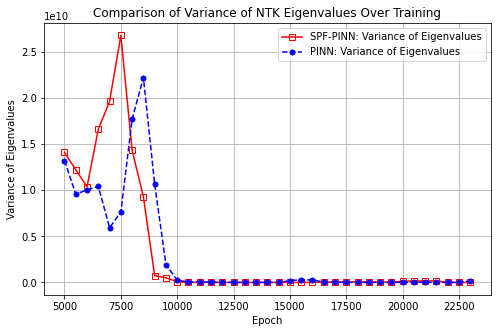

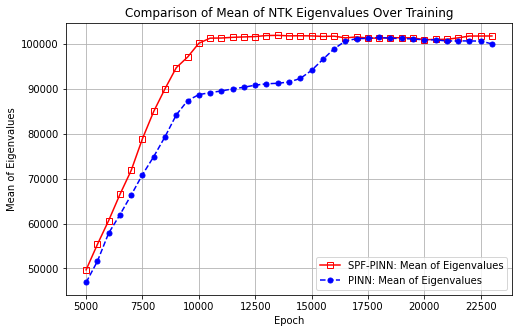

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
start_epoch = 5000
step_interval = 4  # 每隔 4 轮计算一次
interval = 500  # 训练步长，影响 epoch 计算

# 转换为 NumPy 数组
eigenvalues_k_history1 = np.array(eigenvalues_k_history1)
eigenvalues_k_history = np.array(eigenvalues_k_history)

# 计算数量信息
num_snapshots1 = len(eigenvalues_k_history1)
num_snapshots2 = len(eigenvalues_k_history)
assert num_snapshots1 == num_snapshots2, "两组特征值历史长度不匹配"

# 存储计算结果
var_over_time1, mean_over_time1, var_over_time2, mean_over_time2 = [], [], [], []
epochs = []

# 计算滑动窗口的方差和均值
for i in range(num_snapshots1 - step_interval):
    epoch = (i + 1) * interval
    if epoch >= start_epoch:
        # 计算第一组
        eigenvalues_segment1 = eigenvalues_k_history1[i : i + step_interval]
        eigenvar1 = np.var(eigenvalues_segment1, axis=0)
        eigenmean1 = np.mean(eigenvalues_segment1, axis=0)
        valid_indices1 = eigenmean1 >= 1e-3
        filtered_eigenmean1 = eigenmean1[valid_indices1]

        # 计算第二组
        eigenvalues_segment2 = eigenvalues_k_history[i : i + step_interval]
        eigenvar2 = np.var(eigenvalues_segment2, axis=0)
        eigenmean2 = np.mean(eigenvalues_segment2, axis=0)
        valid_indices2 = eigenmean2 >= 1e-3
        filtered_eigenmean2 = eigenmean2[valid_indices2]

        # 计算整体均值和方差
        var_over_time1.append(np.mean(eigenvar1))
        mean_over_time1.append(np.mean(filtered_eigenmean1) if len(filtered_eigenmean1) > 0 else 0)

        var_over_time2.append(np.mean(eigenvar2))
        mean_over_time2.append(np.mean(filtered_eigenmean2) if len(filtered_eigenmean2) > 0 else 0)

        epochs.append(epoch)

# **第一张图：方差随 Epoch 变化**
plt.figure(figsize=(8, 5))
plt.plot(epochs, var_over_time1, marker='s', linestyle='-', color='r', markerfacecolor='none' ,label="SPF-PINN: Variance of Eigenvalues")
plt.plot(epochs, var_over_time2, marker='o', linestyle='--', color='b',markersize=5, label="PINN: Variance of Eigenvalues")
plt.xlabel("Epoch")
plt.ylabel("Variance of Eigenvalues")
plt.title("Comparison of Variance of NTK Eigenvalues Over Training")
plt.legend()
plt.grid(True)

plt.figure(figsize=(8, 5))
plt.plot(epochs, mean_over_time1, marker='s', linestyle='-', markerfacecolor='none', color='r', label="SPF-PINN: Mean of Eigenvalues")
plt.plot(epochs, mean_over_time2, marker='o', linestyle='--', color='b',markersize=5, label="PINN: Mean of Eigenvalues")
plt.xlabel("Epoch")
plt.ylabel("Mean of Eigenvalues")
plt.title("Comparison of Mean of NTK Eigenvalues Over Training")
plt.legend()
plt.grid(True)

